# Core: Exploring and understanding the Data

All imports are sorted and copy from the imports that I use in assignment2.

In [69]:

# importing pandas, and other necessary modules
import glob
import io
import sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt  # visualising
import missingno as msno
import numpy as np  # linear algebra
# import pandas, and other necessary modules
import pandas as pd  # data processing
# easy for structing the report , need pip install pandas-profiling first
import pandas_profiling as pp
import phik
import pydotplus
import seaborn as sns  # visualising
import sklearn
from IPython.display import Image
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
from numpy import asarray, cov, isnan, mean, polyfit
from scipy.stats import pearsonr
from sklearn import datasets, metrics, preprocessing, tree
from sklearn.cluster import KMeans
# import sklearn
from sklearn.datasets import (make_blobs, make_circles,  # , load_iris
                              make_classification, make_hastie_10_2,
                              make_moons)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  PassiveAggressiveClassifier, RidgeClassifier,
                                  SGDClassifier)
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import (KFold, LeaveOneOut, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
# Encoding categorical features with preserving the missing values in incomplete features
from sklearn.preprocessing import (KBinsDiscretizer, LabelEncoder,
                                   OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.tree import (DecisionTreeClassifier, DecisionTreeRegressor,
                          ExtraTreeClassifier)

import myutil  # myutil

# 0. load dataset and merged them into 1 whole dataset.

In [70]:
alternative = pd.read_csv('datasets/alternative.csv')
anime = pd.read_csv("datasets/anime.csv")
blues = pd.read_csv('datasets/blues.csv')
classical = pd.read_csv('datasets/classical.csv')
country = pd.read_csv('datasets/country.csv')
electronics = pd.read_csv('datasets/electronic.csv')
hip_hop = pd.read_csv('datasets/hip-hop.csv')
jazz = pd.read_csv('datasets/jazz.csv')
rap = pd.read_csv('datasets/rap.csv')
rock = pd.read_csv('datasets/rock.csv')
# test_instances = pd.read_csv('datasets/testing-instances.csv')

dataset_list = [
    alternative,
    anime,
    blues,
    classical,
    country,
    electronics,
    hip_hop,
    jazz,
    rap,
    rock
]

# dataset_name_list = ["alternative", "anime", "blues", "classical",
#                      "country", "electronics", "hip_hop", "jazz", "rap", "rock"]
# name_dataset_map = dict(zip(dataset_name_list, dataset_list))

# set the pd to display every rows and cols, so no folding
pd.set_option("display.max_rows", None, "display.max_columns", None)


def merge_multi_datasets(data_list=dataset_list):
    '''merge multiple dataset into one and then return it.
    For example, in data_list, it hold rock,rap ... etc, this method will merge it  using outer
    '''
    merged_all = pd.DataFrame()
    # print(merged_all)
    for dataset in data_list:
        # In order to merge the data without errors, we need to align the index of the "Country/Area" column to keep consistency between data frames. We reset the index value from 0 by sorting the "Country/Area" column in each dataset
        dataset.sort_values(by=['instance_id'], inplace=True)

        # reset index values so dataframes can be merged without errors
        data_to_be_merged = dataset.reset_index(drop=True)

        # 4. finially, merged datasets.
        if merged_all.empty:
            merged_all = data_to_be_merged
        else:
            merged_all = pd.merge(merged_all, data_to_be_merged, how='outer')

    return merged_all
# type(rock)


# check the shapes and if there is any missing values



merged_dataset = merge_multi_datasets()

print(merged_dataset.columns)
print(merged_dataset.shape)


Index(['instance_id', 'artist_name', 'track_hash', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')
(50000, 19)


# 1. Clean the potential dirty data.

such as duplicated, missing, etc.

check whether there are conspicuous NA, which is any missing features among all rows.

In [71]:
print(merged_dataset.info())
myutil.print_NA_details(merged_dataset)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  int64  
 1   artist_name       50000 non-null  object 
 2   track_hash        50000 non-null  object 
 3   track_name        50000 non-null  object 
 4   popularity        50000 non-null  int64  
 5   acousticness      50000 non-null  float64
 6   danceability      50000 non-null  float64
 7   duration_ms       50000 non-null  int64  
 8   energy            50000 non-null  float64
 9   instrumentalness  50000 non-null  float64
 10  key               50000 non-null  object 
 11  liveness          50000 non-null  float64
 12  loudness          50000 non-null  float64
 13  mode              50000 non-null  object 
 14  speechiness       50000 non-null  float64
 15  tempo             50000 non-null  object 
 16  obtained_date     50000 non-null  object

No conspicuous missing. 

Then, check if there are any duplicates based on `track_hash` and `track_name`

In [72]:
# merged_dataset.tail()
duplicateDFRow = merged_dataset[merged_dataset.duplicated(['track_hash','track_name'])]
print(duplicateDFRow)

Empty DataFrame
Columns: [instance_id, artist_name, track_hash, track_name, popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, obtained_date, valence, music_genre]
Index: []


From above, we know that there are no conspicuous missing and duplicates.  

generate the `panda profile report and export it as html`

Not display to widget is because I am using vs code and when quit and reopen again, it will disappear. Therefore, read it via static html is more friendly to myself.

In [73]:
# profile_report = pp.ProfileReport(merged_dataset)
# # export to html, since look at the static HTML is more friendly to me  
# profile_report.to_file('panda-profile-report/before_merged_dataset.html')
merged_dataset.head()


,instance_id,artist_name,track_hash,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,20012,Avenged Sevenfold,0caajoOsHzQOZtIXitnRUN,Requiem,49,0.000104,0.532,261573,0.953,0.007650,G#,0.119,-5.667,Major,0.0394,142.016,4-Apr,0.485,Alternative
1,20018,BADBADNOTGOOD,0bdabO15YOj0iZPg2OujAw,In Your Eyes (feat. Charlotte Day Wilson),50,0.430000,0.495,247055,0.533,0.000672,C,0.106,-5.802,Minor,0.0295,79.71,4-Apr,0.424,Alternative
2,20042,System Of A Down,0blIe8ZSUusQfh4hvBNWoD,F**k The System,48,0.002160,0.474,132733,0.994,0.126000,G#,0.314,-1.884,Major,0.1030,171.433,4-Apr,0.847,Alternative
3,20057,Jeremy Camp,0CBM2iiBZmfKntDeQYboqU,There Will Be A Day,48,0.109000,0.344,279440,0.667,0.000000,F#,0.103,-5.705,Major,0.0385,77.291,4-Apr,0.208,Alternative
4,20066,Three Days Grace,0c1gHntWjKD7QShC8s99sq,It's All Over,50,0.003050,0.321,249320,0.820,0.000000,C,0.340,-4.459,Minor,0.0422,?,4-Apr,0.198,Alternative


**read csv again since we need to specify which values are missing and/or unusual.** 

It is because there are potential missing values.
For instances, in `tempo`, there are `?`. ANd for 'duration_ms', there are `-1`,which are missing values.

In [74]:
merged_dataset.to_csv("datasets/merged_all.csv", encoding='utf-8', index=False)
merged_dataset = pd.read_csv("datasets/merged_all.csv",na_values=['?','NA','missing','not available','-','-1','empty_field'])
myutil.print_NA_details(merged_dataset)
merged_dataset.head()


missing feature and values:
 artist_name    2489
duration_ms    4939
tempo          4980
dtype: int64


,instance_id,artist_name,track_hash,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,20012,Avenged Sevenfold,0caajoOsHzQOZtIXitnRUN,Requiem,49,0.000104,0.532,261573.0,0.953,0.007650,G#,0.119,-5.667,Major,0.0394,142.016,4-Apr,0.485,Alternative
1,20018,BADBADNOTGOOD,0bdabO15YOj0iZPg2OujAw,In Your Eyes (feat. Charlotte Day Wilson),50,0.430000,0.495,247055.0,0.533,0.000672,C,0.106,-5.802,Minor,0.0295,79.710,4-Apr,0.424,Alternative
2,20042,System Of A Down,0blIe8ZSUusQfh4hvBNWoD,F**k The System,48,0.002160,0.474,132733.0,0.994,0.126000,G#,0.314,-1.884,Major,0.1030,171.433,4-Apr,0.847,Alternative
3,20057,Jeremy Camp,0CBM2iiBZmfKntDeQYboqU,There Will Be A Day,48,0.109000,0.344,279440.0,0.667,0.000000,F#,0.103,-5.705,Major,0.0385,77.291,4-Apr,0.208,Alternative
4,20066,Three Days Grace,0c1gHntWjKD7QShC8s99sq,It's All Over,50,0.003050,0.321,249320.0,0.820,0.000000,C,0.340,-4.459,Minor,0.0422,NaN,4-Apr,0.198,Alternative


Do the pearson and Phik heatMap. 
For obervaing the corr value, in order to find important feature.

In [75]:
# def find_feature_name_of_Y(cor, method_name, dataset=merged_dataset, corr_val=0.5, class_label='music_genre'):
#     """
#     find matched feature name with class_label where the the corr() should be bigger than corr_val 
#     return a list of column strings, does not count music_genre itself 

#     cor: the dataframe contains only corr values. such as :
#             pearson = dataset.corr()
#             phik = dataset.phik_matrix()
#     """
#     phik_matrix = dataset.phik_matrix()

#     print('-'*80)
#     print(method_name)
#     cor_target = cor[class_label]
#     relevant_features = cor_target[(cor_target > 0.5)]
#     print(relevant_features)
#     print('-'*80)
#     features_list = []
#     for col in dataset.columns:
#         if col == class_label:
#             continue
#         c1 = -999
#         if method_name == 'pearson':
#             c1, _ = pearsonr(dataset[class_label], dataset[col])
#         else:
#             c1 = phik_matrix[class_label][col]
#         if(c1 >= corr_val):
#             features_list.append(col)
#     return features_list

# myutil.plot_heatmap(merged_dataset.corr(),'pearson after merging')


In [76]:
# high_corr_features = find_feature_name_of_Y(cor=merged_dataset.phik_matrix(),method_name='phik')
# high_corr_features

## delete instance_id field, since this is 100% unnecessuary feature.
> https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe

In [77]:
# the index of instance_id is 0
merged_dataset.drop(merged_dataset.columns[[0]], axis=1, inplace=True)
merged_dataset.tail()  # check if it delete successfully


,artist_name,track_hash,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
49995,The Beatles,7hpFYWL3cw5m4y70cce7Zb,Day Tripper - Remastered 2015,68,0.1200,0.665,169000.0,0.782,0.000004,F#,0.125,-8.438,Minor,0.0307,137.453,4-Apr,0.731,Rock
49996,The Beatles,7JRN5xOUIrnI4crUMOt6X4,I Feel Fine - Remastered 2015,63,0.0904,0.564,139347.0,0.827,0.000004,G,0.127,-7.089,Major,0.0283,89.847,4-Apr,0.912,Rock
49997,Sugarland,507bYMYfbm6sUS9iEAaeSd,Something More,53,0.3130,0.590,216733.0,0.850,0.000000,E,0.116,-4.419,Major,0.0582,102.265,4-Apr,0.415,Rock
49998,Vinyl Theatre,7IQsZqlZ53UIXFjzHOkraF,Breaking Up My Bones,61,0.0125,0.608,185429.0,0.899,0.000000,D,0.211,-3.185,Major,0.0392,105.032,4-Apr,0.652,Rock
49999,MKTO,7K8KNuwZAKKktkfPMosFsM,American Dream,64,0.1140,0.554,225747.0,0.767,0.000000,C,0.231,-5.043,Major,0.0497,122.846,4-Apr,0.497,Rock


## only delete NA for `artist_name` feature since it is MCAR and it is under 5%

This stackoverflow contains everything about different ways of delete NA:
> https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan

In [78]:

# TODO: FIXME: It can be upgraded in the future! Maybe in completion or challenge part!
# For this one, it may use feature transformation

print("Shape: Before delete artist_name NA:",merged_dataset.shape)
whole_noArtistName = merged_dataset.dropna(subset = ['artist_name'], inplace=False)
print("Shape: After delete artist_name NA:",whole_noArtistName.shape)


Shape: Before delete artist_name NA: (50000, 18)
Shape: After delete artist_name NA: (47511, 18)


Fill the rest NA by mean value.

TODO: FIXME: It can be upgraded in the future! Maybe in completion or challenge part!

In [79]:
# TODO: FIXME: It can be upgraded in the future! Maybe in completion or challenge part!
whole_noMissing = whole_noArtistName.copy()


print('before:')
print(myutil.print_NA_details(whole_noMissing))
print(whole_noMissing.shape)
print('-'*80)

# whole_noMissing['tempo'].fillna((whole_noMissing['tempo'].mean()), inplace=True)
# whole_noMissing['duration_ms'].fillna((whole_noMissing['duration_ms'].mean()), inplace=True)
whole_noMissing =  myutil.replace_by_mean(whole_noMissing)

print('-'*80)
print('After:')
print(myutil.print_NA_details(whole_noMissing))
print(whole_noMissing.shape)


before:

missing feature and values:
 duration_ms    4696
tempo          4720
dtype: int64
None
(47511, 18)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
After:

missing feature and values:
 Series([], dtype: int64)
None
(47511, 18)


In [80]:

whole_noMissing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47511 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       47511 non-null  object 
 1   track_hash        47511 non-null  object 
 2   track_name        47511 non-null  object 
 3   popularity        47511 non-null  int64  
 4   acousticness      47511 non-null  float64
 5   danceability      47511 non-null  float64
 6   duration_ms       47511 non-null  float64
 7   energy            47511 non-null  float64
 8   instrumentalness  47511 non-null  float64
 9   key               47511 non-null  object 
 10  liveness          47511 non-null  float64
 11  loudness          47511 non-null  float64
 12  mode              47511 non-null  object 
 13  speechiness       47511 non-null  float64
 14  tempo             47511 non-null  float64
 15  obtained_date     47511 non-null  object 
 16  valence           47511 non-null  float6

# Below are From Week7 tutorial. TODO:

By observating the pp report, and output above, i observe that `tempo` should be the numerical feature, but it report that it's categorical feature. This is caused by the value `?` is categorical, and it occur 4980 time, which is less than 10%.

By googling, I think `tempo` a very important feature, from this [tutorial](https://towardsdatascience.com/all-about-missing-data-handling-b94b8b5d2184) and school slide, I find that although it is MCAR, but the missing percentage is greater tahn 5%, which means, just delete it is not an approiate approach, the `imputation` is better approach, so  I decide to try to apply it based on the school tutorial(week7_tut_FCDI.ipynb) using :  
> panda interpolation

In [81]:
# # Now we will split the data to train and test subsets as **ONLY** the training data will be used to learn the imputers then the learnt models are applied to the test data

# X_whole=merged_dataset[merged_dataset.columns[1:-1]]
# y_whole=merged_dataset[merged_dataset.columns[-1]]

# X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole, y_whole, test_size=0.3, random_state=42)

Encoding categorical features with preserving the missing values in incomplete features
```python
from sklearn.preprocessing import OrdinalEncoder
```



In [82]:
# encoder = OrdinalEncoder(
#     handle_unknown='use_encoded_value', unknown_value=np.nan)
# X_whole_train_encoded = X_whole_train.copy()


# X_titanic_train_encoded['sex'] = encoder_sex.fit_transform(
#     X_titanic_train_encoded['sex'].values.reshape(-1, 1))

# # Now lets encode the incomplete Cabin feature
# # You can use the same encoder for both but we use two for the sake of clarfication
# encoder_cabin = OrdinalEncoder(
#     handle_unknown='use_encoded_value', unknown_value=np.nan)
# X_titanic_train_encoded['cabin'] = encoder_cabin.fit_transform(
#     X_titanic_train_encoded['cabin'].values.reshape(-1, 1).astype(str))
# # get the code of the "nan" value for the cabin categorical feature
# cabin_nan_code = encoder_cabin.transform([['nan']])[0][0]
# # print(cabin_nan_code)
# # Now, retrive the nan values to be missing in the encoded data
# X_titanic_train_encoded['cabin'].replace(cabin_nan_code, np.nan, inplace=True)

# # X_titanic_train_encoded is the encoded incomplete training data
# #Check the types of the encoded data, no object features
# X_titanic_train_encoded.info()




# X_whole_data_complete=X_whole_train_encoded.copy()
# X_whole_data_complete=X_whole_data_complete.interpolate()
# #The output is 'numpy.ndarray' so we convert it to dataframe for consistency
# X_whole_train_complete=pd.DataFrame(X_whole_train_complete)

# 2. Encoding Categorical data 

Encoding Categorical Variables. This step is for converting categorical data to numerical data. We have 2 categorical variables which are country and regional Indicator, so after this step, they will be translate to numerical data in order forpreparing to the machine learning. I use LabelEncoder() method from tutorial to encode them into the numerical valuesand replace it to the dataset

> https://zhuanlan.zhihu.com/p/117230627
>
> https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type


In [83]:
categorical = {'artist_name', 'track_hash', 'track_name',
               'key', 'obtained_date', 'mode', 'music_genre'}

whole_encode_all = whole_noMissing.copy()

label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder()
hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# 1st, use label encoder to encode mode and the class label: music_genre
# mode has only 2 values, so I think it can use labelEncoder as well


def label_encode_features(dataset, encoder = label_encoder,feature_list=['mode', 'music_genre']):
    for feature in feature_list:
        dataset[feature] = encoder.fit_transform(dataset[feature])
    return dataset


def ordinal_encode_feature(ordinal_encoder, dataset, feature_list=['key', 'obtained_date']):
    '''encode default ['key','obtained_date'] '''
    # feature_list = ['key', 'obtained_date']  # ,'mode']

    for feature in feature_list:
        dataset[feature] = ordinal_encoder.fit_transform(
            dataset[feature].values.reshape(-1, 1))

    return dataset

def one_hot_encoder(hot_encoder,dataset, feature_list=['artist_name', 'track_hash', 'track_name']):
    ''' 3rd, use one hot encoder to encode 'artist_name','track_hash','track_name'''
    # feature_list = ['artist_name', 'track_hash', 'track_name']

    for i in range(len(feature_list)-1):
        dataset[feature_list[i]] = hot_encoder.fit_transform(
            dataset[feature_list[i]].to_numpy().reshape(-1, 1))

    return dataset


whole_encode_all = label_encode_features(
    dataset=whole_encode_all, feature_list=['mode', 'music_genre'])

# 2nd, use ordinal encoder to handle the rest
whole_encode_all = ordinal_encode_feature(
    ordinal_encoder=ordinal_encoder, dataset=whole_encode_all, feature_list=['key', 'obtained_date'])

whole_encode_all = ordinal_encode_feature(ordinal_encoder=ordinal_encoder, dataset=whole_encode_all, feature_list=[
                                          'artist_name', 'track_hash', 'track_name'])

whole_encode_all.info()
whole_encode_all.head()


# FIXME: SHIT, it report the MemoryError: Unable to allocate 14.1 GiB for an array with shape (47511, 39917) and data type float64
# my labtop only has 8 GB RAM, F**K https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type
# # TODO: https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type
# def one_hot_encoder(hot_encoder,dataset, feature_list=['artist_name', 'track_hash', 'track_name']):
#     ''' 3rd, use one hot encoder to encode 'artist_name','track_hash','track_name'''
#     # feature_list = ['artist_name', 'track_hash', 'track_name']
#     for i in range(len(feature_list)-1):
#         dataset[feature_list[i]] = hot_encoder.fit_transform(
#             dataset[feature_list[i]].to_numpy().reshape(-1, 1))
#     return dataset
# # 2nd, use ordinal encoder to encode 'key','obtained_date' these 2 features
# whole_encode_all = myutil.ordinal_encoder(whole_encode_all)

# # 3rd, use one hot encoder to encode 'artist_name','track_hash','track_name'
# # whole_encode_all = myutil.one_hot_encoder(whole_encode_all)
# feature_list = ['artist_name','track_hash','track_name']
# whole_encode_all = myutil.one_hot_encoder(whole_encode_all,feature_list=feature_list)

# whole_encode_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47511 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       47511 non-null  float64
 1   track_hash        47511 non-null  float64
 2   track_name        47511 non-null  float64
 3   popularity        47511 non-null  int64  
 4   acousticness      47511 non-null  float64
 5   danceability      47511 non-null  float64
 6   duration_ms       47511 non-null  float64
 7   energy            47511 non-null  float64
 8   instrumentalness  47511 non-null  float64
 9   key               47511 non-null  float64
 10  liveness          47511 non-null  float64
 11  loudness          47511 non-null  float64
 12  mode              47511 non-null  int32  
 13  speechiness       47511 non-null  float64
 14  tempo             47511 non-null  float64
 15  obtained_date     47511 non-null  float64
 16  valence           47511 non-null  float6

,artist_name,track_hash,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,460.0,5618.0,26336.0,49,0.000104,0.532,261573.0,0.953,0.007650,11.0,0.119,-5.667,0,0.0394,142.016000,3.0,0.485,0
1,488.0,5431.0,16020.0,50,0.430000,0.495,247055.0,0.533,0.000672,3.0,0.106,-5.802,1,0.0295,79.710000,3.0,0.424,0
2,5573.0,5455.0,10033.0,48,0.002160,0.474,132733.0,0.994,0.126000,11.0,0.314,-1.884,0,0.1030,171.433000,3.0,0.847,0
3,2808.0,2233.0,33731.0,48,0.109000,0.344,279440.0,0.667,0.000000,9.0,0.103,-5.705,0,0.0385,77.291000,3.0,0.208,0
4,6135.0,5508.0,16438.0,50,0.003050,0.321,249320.0,0.820,0.000000,3.0,0.340,-4.459,1,0.0422,119.960525,3.0,0.198,0


# 3. Normalisation. 

This step is to transform columns to a consistent set of rules, which means need to meet the convention.Due to the scales of each feature  is different and not unified, and some machine learning methods are greatly affectedby it, so this step is fundamental and essential. I normalize all the feature columns except for the ladder score to theconsistent set of scales

In [84]:
scaler = StandardScaler()

# iterate each col and do the normalization
for (columnName, columnData) in whole_encode_all.iteritems():
    # music_genre is Class Label Y, so dont need to do anything
    if columnName == "music_genre":
        continue
    
    whole_encode_all[columnName] = scaler.fit_transform(columnData.values.reshape(-1,1))


# 4. Discretisation.

***`Dont really need this step since for the class label, we've already use the Label encoder to encode`***

 ~~Since the happiness ladder score is the target and it is discreate numerical, so in order to do the machinelearning, this attribute need to be converted to the nominal attribute. I apply the discretisation to transform it into 4different happiness ladder levels, so that the machine is able to learn~~

In [85]:
# est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# # print(est.fit_transform(df.Temperature.values.reshape(-1, 1)))

# whole_encode_all["music_genre"] = est.fit_transform(
#     whole_encode_all["music_genre"].values.reshape(-1, 1))

# whole_encode_all.rename(columns={'music_genre': 'class'}, inplace=True)



In [86]:
# profile_report = pp.ProfileReport(whole_encode_all)
# # export to html, since look at the static HTML is more friendly to me  
# profile_report.to_file('panda-profile-report/encode_all.html')

In [87]:
whole_encode_all.tail(10)


,artist_name,track_hash,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
49990,1.672676,1.026328,0.151748,0.887023,-0.852537,0.098502,-0.394892,1.267898,-0.558561,-1.548514,0.959751,0.839006,-0.747331,-0.416575,-0.486529,0.233448,1.135846,9
49991,1.263795,1.257395,-1.280574,1.980870,0.135150,-0.035834,-0.787931,0.060336,-0.558576,-0.391894,-0.889935,-0.107279,1.338094,-0.582730,-0.258341,0.233448,0.852590,9
49992,0.700515,1.126675,-1.080064,2.109558,-0.847258,-0.030237,0.356520,1.002916,-0.558544,-1.548514,0.452310,0.710927,1.338094,-0.520422,-0.817764,0.233448,1.127753,9
49993,1.164215,1.087325,-0.400308,0.436615,0.363890,0.216047,-0.991343,0.488093,-0.557713,-1.548514,-0.166521,0.938640,-0.747331,-0.601521,0.004311,0.233448,1.034683,9
49994,1.354322,1.118872,1.414590,0.436615,-0.658401,-1.754223,-0.098245,0.435097,-0.558576,1.343036,0.910244,0.476713,-0.747331,-0.557016,-1.543905,0.233448,-0.361368,9
49995,1.159186,1.649304,-1.069226,1.530462,-0.545204,0.596667,-0.725057,0.688722,-0.558563,1.053881,-0.426430,0.111657,1.338094,-0.621302,0.601051,0.233448,1.111567,9
49996,1.159186,1.558521,-0.448556,1.208743,-0.632008,0.031334,-1.006391,0.859068,-0.558564,1.343036,-0.414054,0.330918,-0.747331,-0.645038,-1.034717,0.233448,1.843988,9
49997,1.052062,1.060308,0.833078,0.565303,0.020780,0.176865,-0.272190,0.946134,-0.558576,0.475571,-0.482125,0.764889,-0.747331,-0.349322,-0.608028,0.233448,-0.167135,9
49998,1.514253,1.542748,-1.326374,1.080055,-0.860455,0.277618,-0.569187,1.131621,-0.558576,-0.102739,0.105764,0.965459,-0.747331,-0.537235,-0.512952,0.233448,0.791892,9
49999,0.139750,1.569848,-1.565605,1.273087,-0.562800,-0.024640,-0.186669,0.631940,-0.558576,-0.681049,0.229530,0.663467,-0.747331,-0.433388,0.099146,0.233448,0.164680,9


In [88]:
whole_encode_all.columns

Index(['artist_name', 'track_hash', 'track_name', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date',
       'valence', 'music_genre'],
      dtype='object')

# For dimension reduction.
> delete cols:

> +  https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe

interval columns not set, guessing: ['artist_name', 'track_hash', 'track_name', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre']


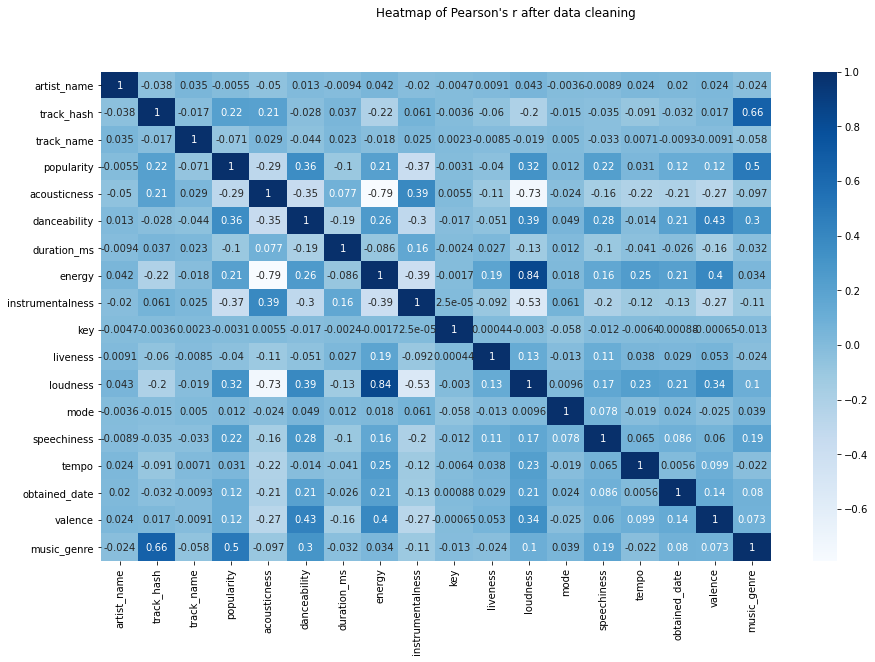

In [89]:

# the heatmap of Pearson's r

pearson = whole_encode_all.corr()
phik = whole_encode_all.phik_matrix()


myutil.plot_heatmap(pearson, "Pearson's r after data cleaning")



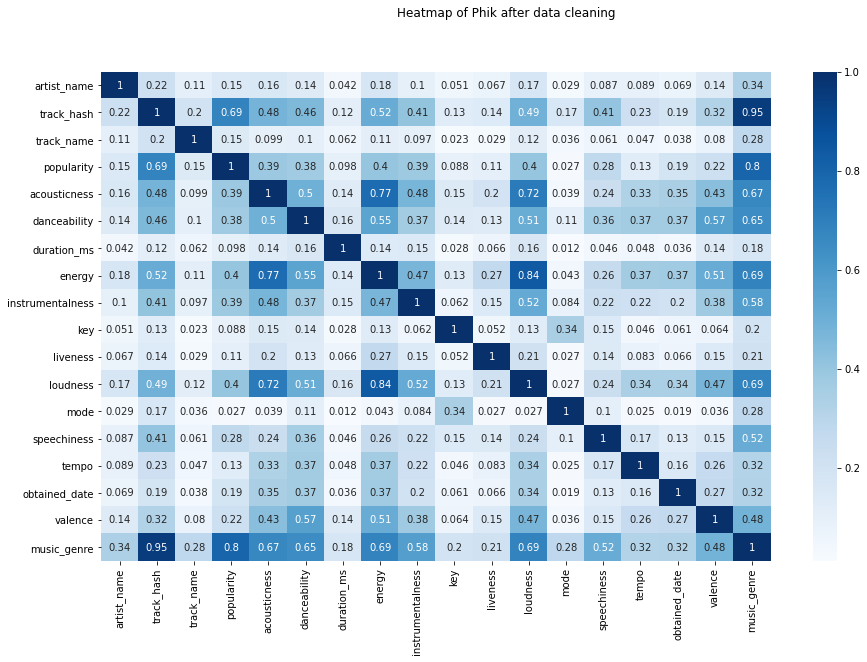

In [90]:
myutil.plot_heatmap(phik, "Phik after data cleaning")
# plot_heatmap(phik, "Phik")

In [91]:
# sns.boxplot(x='Ladder Score', y='Regional indicator',data=whole_encode_all).set_title('2017 Regional vs happiness score')

In [92]:
def find_feature_name(cor, method_name, dataset=whole_encode_all, corr_val=0.5, class_label='music_genre'):
    """
    find matched feature name with class_label where the the corr() should be bigger than corr_val 
    return a list of column strings, does not count music_genre itself 

    cor: the dataframe contains only corr values. such as :
            pearson = dataset.corr()
            phik = dataset.phik_matrix()
    """
    phik_matrix = dataset.phik_matrix()

    print('-'*80)
    print(method_name)
    cor_target = cor[class_label]
    relevant_features = cor_target[(cor_target > 0.5)]
    print(relevant_features)
    print('-'*80)
    features_list = []
    for col in dataset.columns:
        if col == class_label:
            continue
        c1 = -999
        if method_name == 'pearson':
            c1, _ = pearsonr(dataset[class_label], dataset[col])
        else:
            c1 = phik_matrix[class_label][col]
        if(c1 >= corr_val):
            features_list.append(col)
    return features_list


def find_feature_name_between_2_vars(cor_method_name, var1, dataset=whole_encode_all, corr_val=0.5):
    """
    For feature interaction purpose(Core Q1). Find matched features between var1O(i.e. feature) and all other features

    return a list of column strings, does not count var1 itself 
    """
    phik_matrix = dataset.phik_matrix()
    features_list = []
    for col in dataset.columns:
        if col == var1:  # do not count itself, since it is always 1
            continue
        c1 = -999
        if cor_method_name == 'pearson':
            c1, _ = pearsonr(dataset[var1], dataset[col])
        else:  # phik
            c1 = phik_matrix[var1][col]
        if(c1 >= corr_val):
            features_list.append(col)

    return features_list


phik_feature_list = find_feature_name(cor=phik, method_name='phik')
pearson_feature_list = find_feature_name(cor=pearson, method_name='pearson')
# print(phik_feature_list)
# print(pearson_feature_list)

# use set to make sure no duplicates, and then back to list
matched_features = list(set(phik_feature_list+pearson_feature_list))
print('-'*80 + '\nFinal mathced features:'+'\nsize:', len(matched_features))
matched_features


interval columns not set, guessing: ['artist_name', 'track_hash', 'track_name', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre']
--------------------------------------------------------------------------------
phik
track_hash          0.952540
popularity          0.796770
acousticness        0.670964
danceability        0.646285
energy              0.685359
instrumentalness    0.578063
loudness            0.687019
speechiness         0.515915
music_genre         1.000000
Name: music_genre, dtype: float64
--------------------------------------------------------------------------------
interval columns not set, guessing: ['artist_name', 'track_hash', 'track_name', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',

['danceability',
 'loudness',
 'popularity',
 'track_hash',
 'acousticness',
 'instrumentalness',
 'speechiness',
 'energy']

For features interactions:


In [93]:
# find_feature_name_between_2_vars(cor_method_name=phik,var1=matched_features[0])

# Finish Cleaning,Start to train and test.

# Random Forest

1. Use only features that are candidates(i.e. in matched_feature list).

My code are from:
> https://scikit-learn.org/stable/modules/cross_validation.html
>
> https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold
>
> https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/



In [94]:
# print(matched_features)
matched_features_copy = matched_features.copy()
matched_features_copy.remove('track_hash') #TODO: Remove track_hash
print('Keeped features:\n',matched_features_copy,"\n","-"*50)

# X = whole_encode_all[whole_encode_all.columns[1:-1]]
# y = whole_encode_all[whole_encode_all.columns[-1]]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=1)

# X_train = X_train[matched_features_copy]
# X_test = X_test[matched_features_copy]

# clf = RandomForestClassifier(
#     max_depth=10)#, min_samples_leaf=10, max_features='sqrt')

# clf.fit(X_train, y_train)  # fit it
# classif_score = clf.score(X_test, y_test)
# print('-'*80, "\nThe performance on provided dataset: \nfinially, we can see:\n for random forest classifier, the mean accuracy is: \n\t\t\t\t\t", classif_score)

# create the dataset
def get_dataset():
    X = whole_encode_all[whole_encode_all.columns[1:-1]]
    y = whole_encode_all[whole_encode_all.columns[-1]]
    return X, y

# retrieve the model to be evaluate
def get_model():
	model = RandomForestClassifier(max_depth=10)
	return model
 
# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = get_dataset()
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()
 
# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,8) #only from 2 to 8 is because it's time consuming
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()

Keeped features:
 ['danceability', 'loudness', 'popularity', 'acousticness', 'instrumentalness', 'speechiness', 'energy'] 
 --------------------------------------------------


KeyboardInterrupt: 

Normal random_forest classifier

In [ ]:
X = whole_encode_all[whole_encode_all.columns[1:-1]]
y = whole_encode_all[whole_encode_all.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

X_train = X_train[matched_features_copy]
X_test = X_test[matched_features_copy]

clf = RandomForestClassifier(
    max_depth=10)#, min_samples_leaf=10, max_features='sqrt')

# define the test condition
cv = KFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
print(scores)

print('-'*80, "\nThe performance on provided dataset: \nfinially, we can see:\n for random forest classifier, the mean accuracy is: \n\t\t\t\t\t", mean(scores))
# clf.fit(X_train, y_train)  # fit it
# classif_score = clf.score(X_test, y_test)
# print('-'*80, "\nThe performance on provided dataset: \nfinially, we can see:\n for random forest classifier, the mean accuracy is: \n\t\t\t\t\t", classif_score)


[0.9412359  0.937279   0.94283549 0.94224131]
-------------------------------------------------------------------------------- 
The performance on provided dataset: 
finially, we can see:
 for random forest classifier, the mean accuracy is: 
					 0.9408979256041995


For test-instance dataset

About how to reverse the calss label:
> https://discuss.analyticsvidhya.com/t/labelencoder-how-to-reverse-it/11497

In [ ]:
print(matched_features_copy)
test_instances = pd.read_csv('datasets/testing-instances.csv', na_values=[
                             '?', 'NA', 'missing', 'not available', '-', '-1'])
#  , 'empty_field'])
print(myutil.print_NA_details(test_instances))

test_instances.drop(
    test_instances.columns[[0]], axis=1, inplace=True)  # drop id

# should not drop artist_name na
# test_instances.dropna(subset = ['artist_name'], inplace=False)

# replace 'duration_ms' and 'tempo' by mean in test set
test_instances = myutil.replace_by_mean(test_instances)
# print(myutil.print_NA_details(test_instances))

# temp_encoder = LabelEncoder()
# test_instances = label_encode_features(
#     test_instances, encoder=temp_encoder, feature_list=['mode'])
# ordinal_encode_feature(ordinal_encoder=ordinal_encoder,
#                        dataset=test_instances, feature_list=['key', 'obtained_date'])
# test_instances = ordinal_encode_feature(ordinal_encoder=ordinal_encoder, dataset=test_instances, feature_list=[
#     'artist_name', 'track_hash', 'track_name'])

# scaler = StandardScaler()
# # iterate each col and do the normalization
# for (columnName, columnData) in test_instances.iteritems():
#     # music_genre is Class Label Y, so dont need to do anything
#     if columnName == "music_genre":
#         continue

#     test_instances[columnName] = scaler.fit_transform(
#         columnData.values.reshape(-1, 1))
# # # test_instances =  test_instances[matched_features_copy]


# test_instances.shape
# classif.predict(test_instances)
predictions_test = clf.predict(test_instances[matched_features_copy])
print(predictions_test)
# predictions_test.shape
predictions_test = label_encoder.inverse_transform(predictions_test)
# print(predictions_test)
df = pd.DataFrame(
    {
        'instance_id': pd.Series(np.arange(start=1, stop=20000, step=1)),
        'music_genre': pd.Series(predictions_test)
    }
)
df["instance_id"] = df.index + 1
# df.iloc[:,0]
df.to_csv("submit.csv", encoding='utf-8', index=False)

['danceability', 'loudness', 'popularity', 'acousticness', 'instrumentalness', 'speechiness', 'energy']

missing feature and values:
 duration_ms    2058
tempo          2081
dtype: int64
None


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.